In [1]:
# As always we start by importing the necessary libraries
# and loading the data we will be working with. (at this point I'm importing stuff just for the fun of it)
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from utility.classification_utility import *

# we define a random state to make the results reproducible
RANDOM_STATE = 42
RUN_SLOW_STUFF = True

cyc = '../dataset/cyclists_cleaned.csv'
races = '../dataset/races_cleaned.csv'

full_df = get_merged_dataset(cyc, races)
full_df = define_target(full_df) 

In [2]:
#full_df = define_target(full_df)
full_df[['points', 'position', 'average_speed', 'stamina_index']]
print('points:', full_df['points'].isna().sum())
print('position:',full_df['position'].isna().sum())
print('average_speed:',full_df['average_speed'].isna().sum())
print('stamina_index:',full_df['stamina_index'].isna().sum())

points: 425399
position: 0
average_speed: 0
stamina_index: 137267


In [3]:
full_df.columns

Index(['_url_rac', 'name_rac', 'stage', 'stage_type', 'points', 'uci_points',
       'length', 'climb_total', 'profile', 'startlist_quality', 'date',
       'position', 'cyclist', 'cyclist_age_rac', 'is_tarmac', 'delta', 'time',
       'time_seconds', 'average_speed', 'steepness', 'season', 'is_staged',
       'race_country', 'norm_points', 'age_performance_index',
       'quality_adjusted_points', 'normalized_length', 'normalized_quality',
       'normalized_steepness', 'normalized_time', 'stamina_index', '_url_cyc',
       'name_cyc', 'birth_year', 'weight', 'height', 'nationality', 'bmi',
       'race_count', 'experience_level', 'total_points', 'victories_by_points',
       'avg_points_per_race', 'average_position', 'avg_speed_cyclist',
       'cyclist_age_cyc', 'mean_stamina_index', 'target'],
      dtype='object')

In [4]:
full_df = recompute_metrics(full_df,
                  victories_by_points_D=-1,
                  avg_points_per_race_D=-1,
                  average_position_D=-1,
                  avg_speed_cyclist_D=-1,
                  mean_stamina_index=-1,
                  total_points_D=-1,
                  missing_value_policy='mean')

In [6]:
stef = full_df[full_df['cyclist'] == 'tadej-pogacar']
stef_sorted = stef.sort_values(by='date')
stef_sorted[['_url_rac', 'cyclist', 'points', 'total_points', 'date', 'position', 'avg_points_per_race']]

,_url_rac,cyclist,points,total_points,date,position,avg_points_per_race
27685,strade-bianche/2019/result,tadej-pogacar,5.0,-1.000000,2019-03-09,29,-1.000000
484309,itzulia-basque-country/2019/stage-2,tadej-pogacar,2.0,5.000000,2019-04-09,8,5.000000
25818,itzulia-basque-country/2019/stage-3,tadej-pogacar,NaN,7.000000,2019-04-10,77,3.500000
46110,itzulia-basque-country/2019/stage-5,tadej-pogacar,10.0,10.500000,2019-04-12,4,3.500000
135514,itzulia-basque-country/2019/stage-6,tadej-pogacar,10.0,20.500000,2019-04-13,4,5.125000
...,...,...,...,...,...,...,...
434236,tour-de-france/2023/stage-16,tadej-pogacar,70.0,6424.423811,2023-07-18,1,44.614054
80691,tour-de-france/2023/stage-17,tadej-pogacar,NaN,6494.423811,2023-07-19,21,44.789130
124202,tour-de-france/2023/stage-18,tadej-pogacar,NaN,6539.212941,2023-07-20,25,44.789130
266480,tour-de-france/2023/stage-19,tadej-pogacar,NaN,6584.002070,2023-07-21,41,44.789130


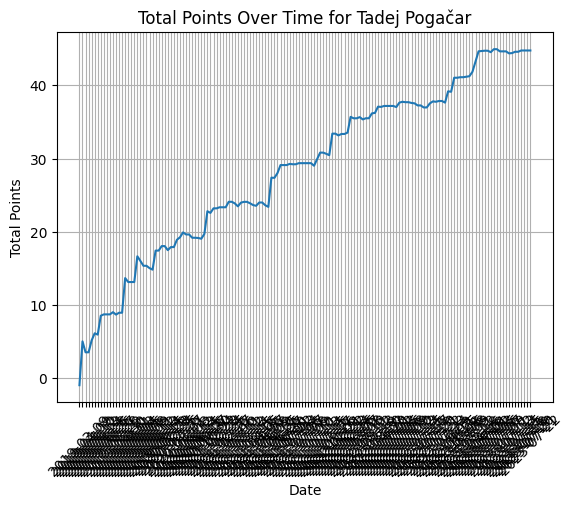

In [ ]:
total_points = list(stef_sorted['avg_points_per_race'])
plt.plot(stef_sorted['date'], total_points)
plt.xlabel('Date')
plt.ylabel('Total Points')
plt.title('Average Points Over Time for Tadej Pogačar')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [ ]:
import os
import sys
from random import shuffle
sys.path.insert(1, os.path.join(sys.path[0], '../..'))

from xgboost import XGBClassifier # XGBoost classifier
from time import time # to compute time
from itertools import product #for grid search
from tqdm import tqdm # for progress bar
from sklearn.metrics import classification_report, f1_score # for evaluation
from utilsData import dataset_loader, load_data # for loading data
from imblearn.over_sampling import RandomOverSampler # for oversampling
f1_macro = lambda x, y: f1_score(x, y, average='macro') # for our evaluation

folderName = f'./Datasets/Cleaned_Dataset_{years_to_death}Y/chl_dataset_known.csv'

# TODO: complete gridsearch adding various sampling strategies
oversample = RandomOverSampler(sampling_strategy='minority', random_state=42)
tr_data, tr_out = oversample.fit_resample(tr_data, tr_out)

# Hyperparameters
N_estimators = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400]
Learning_rate = [0.001, 0.005, 0.01, 0.05, 0.1]
# Shuffle hyperparameters
hyperparameters = list(product(N_estimators, Learning_rate))
shuffle(hyperparameters)

# Grid search
best_score = 0
best_params = None
for n_estimators, learning_rate in tqdm(hyperparameters, total=len(hyperparameters)):
    xgb_model = XGBClassifier(
        n_estimators=n_estimators, 
        learning_rate=learning_rate, 
        n_jobs=-1, 
        random_state=42,
        objective='binary:logistic'
    )
    xgb_model.fit(tr_data, tr_out)
    val_pred = xgb_model.predict(val_data)
    score = f1_macro(val_out, val_pred)
    if score > best_score:
        best_score = score
        best_params = (n_estimators, learning_rate)

# Train the model with the best hyperparameters
n_estimators, learning_rate = best_params
xgb_model = XGBClassifier(
    n_estimators=n_estimators, 
    learning_rate=learning_rate, 
    n_jobs=-1, 
    random_state=42,
    objective='binary:logistic'
)
xgb_model.fit(tr_data, tr_out)

# Predict
val_pred = xgb_model.predict(val_data)
print(f'val f1-score: {f1_macro(val_out, val_pred)}')
print(classification_report(val_out, val_pred))
print(f'Best hyperparameters: {best_params}')
print(f'Best score: {best_score}')